# Genre classification results

## Setup

### Import dependencies

In [1]:
# Import packages
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import os
import zipfile
from torch.utils.data import SubsetRandomSampler, DataLoader
from PIL import Image
from torchvision.models import resnet18
from tqdm import tqdm
import csv
import random

C:\Users\ASUS\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Dataloader

In [2]:
# WikiART224
def get_data_loaders(data_dir, batch_size=64, num_workers=1):

    '''
    input:
    data_dir: file path of input data. raw_dataset are created from that file
    batch_size
    num_workers
    output:
    train_loader, val_loader, test_loader
    -----
    data is transformed by data_transform. train:val:test = 0.8:0.1:0.1 with each classes equally splitted
    '''
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    indices = np.arange(len(raw_dataset))
    np.random.shuffle(indices)
    train_split = int(len(indices) * 0.8)
    # dividing by 2 will assign 10% to val and 10% to test
    # if the train is 0.8
    testval_split = train_split + int(len(indices) * (1 - 0.8)/2)
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split] ,indices[testval_split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                            num_workers=num_workers, sampler=val_sampler)
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=test_sampler)
    print(f'data loading completed')
    return train_loader, val_loader, test_loader

In [ ]:
# WikiART9 Center crop data loader
def get_data_loaders(data_dir, batch_size=64, num_workers=1):
    '''
    input:
    data_dir: file path of input data. raw_dataset are created from that file
    pattern: pattern to match in file names
    batch_size
    num_workers
    output:
    train_loader, val_loader, test_loader
    -----
    data is transformed by data_transform. train:val:test = 0.8:0.1:0.1 with each classes equally splitted
    '''

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    
    # Filter and keep only the files with "crop_1_1" in the filename
    raw_dataset.samples = [(img, label) for img, label in raw_dataset.samples if 'crop_1_1' in os.path.basename(img)]
    raw_dataset.targets = [label for _, label in raw_dataset.samples]

    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    indices = np.arange(len(raw_dataset))
    np.random.shuffle(indices)
    train_split = int(len(indices) * 0.8)
    testval_split = train_split + int(len(indices) * (1 - 0.8)/2)

    # Split into training, validation, and test indices
    relevant_train_indices, relevant_val_indices, test_indices = indices[:train_split], indices[train_split:testval_split], indices[testval_split:]

    # Create DataLoader with SubsetRandomSampler
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)

    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler)

    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_sampler)

    print('Data loading completed')
    return train_loader, val_loader, test_loader

### Training code

In [3]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
    return path

In [4]:
# Function to evaluate model performance
def evaluate_model(model, data_loader, k=3):
    
    model.eval()
    
    #############################################
    # To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        model.cuda()
    ############################################# 
    
    num_classes = len(train_loader.dataset.classes)
    
    true_positives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes
    correct = 0
    total = 0
    correct_at_k = 0
    
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################

        output = model(imgs)
        
        # Get top-k predictions
        _, pred_topk = output.topk(k, dim=1)
        
        #select index with maximum prediction score
        preds = output.max(1, keepdim=True)[1]
        correct += preds.eq(labels.view_as(preds)).sum().item()
        
        # Check if true label is in top-k predictions
        for i in range(len(labels)):
            if labels[i] in pred_topk[i]:
                correct_at_k += 1
                
        total += imgs.shape[0]
        
        # Update counts of true positives, false positives, and false negatives
        for pred, label in zip(preds, labels):
            if pred == label:
                true_positives[pred] += 1
            else:
                false_positives[pred] += 1
                false_negatives[label] += 1
      
    precisions = []
    recalls = []
    f1_scores = []
    for i in range(num_classes):
        tp = true_positives[i]
        fp = false_positives[i]
        fn = false_negatives[i]

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(2 * (precision * recall) / (precision + recall + 1e-9))      
        
    return correct / total, correct_at_k / total, precisions, recalls, f1_scores

In [5]:
def train(model, dataset_dir, batch_size=64, learning_rate=0.001, num_epochs=10):

    #############################################
    # To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        model.cuda()
    #############################################

    # Instantiate data_loader for training and validation datasets
    train_loader, val_loader, _ = get_data_loaders(dataset_dir, batch_size)

    # Set criterion to CE
    criterion = nn.CrossEntropyLoss()

    # Set optimizer to Adam
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Instantiate empty lists to store iterations, losses, and training and validation accuracies
    epochs, train_acc, val_acc = [], [], []

    # Training
    print('Training has started!')
    epoch_idx = 0
    # Iterate through epochs
    for epoch in range(num_epochs):
        # Set running_loss to 0.0
        running_loss = 0.0
        i = 0

        # Create tqdm progress bar for training batches
        loop = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)

        for imgs, labels in loop:
            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

            out = model(imgs)             # Forward pass
            loss = criterion(out, labels) # Compute the total loss
            loss.backward()               # Backward pass (compute parameter updates)
            optimizer.step()              # Make the updates for each parameter
            optimizer.zero_grad()         # A clean-up step for PyTorch
            running_loss += loss.item()  # Add the loss to the running_loss

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]") # Set description of progress bar
            loop.set_postfix(loss=running_loss/(i+1))
            i += 1

        if epoch % 2 == 0:
            # Save the training information per epoch
            train_acc.append(get_accuracy(model, train_loader)) # Compute training accuracy
            val_acc.append(get_accuracy(model, val_loader))     # Compute validation accuracy
            epochs.append(epoch)

            # Print Training and validation accuracy at each epoch
            print(f'Epoch {epoch}---Training accuracy: {train_acc[epoch_idx]}---Validation accuracy: {val_acc[epoch_idx]}')
            epoch_idx += 1

            # Save the current model (checkpoint) to a file at every epoch
            model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
            torch.save(model.state_dict(), model_path)


    print('Training done!')

    return epochs, train_acc, val_acc

# Training Results

## WikiART224

### ResNet18 no regularization

Training was done with batch_size = 128, and lr = 0.0012

#### network architecture

In [ ]:
# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
resnet.name = 'ResNet18'

# Freeze parameters in ResNet architecture
for param in resnet.parameters():
    param.requires_grad = False

# Modify the top layer
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 55),
    nn.ReLU(),
    nn.Linear(55, 11))

#### training results

In [5]:
resnet18_noreg_df = pd.read_csv('ResNet18_noreg_results.csv')
resnet18_noreg_df.head()

,epochs,training accuracy,validation accuracy
0,0,0.652835,0.584292
1,2,0.660287,0.584416
2,4,0.681529,0.584787
3,6,0.691826,0.581571
4,8,0.703421,0.575634


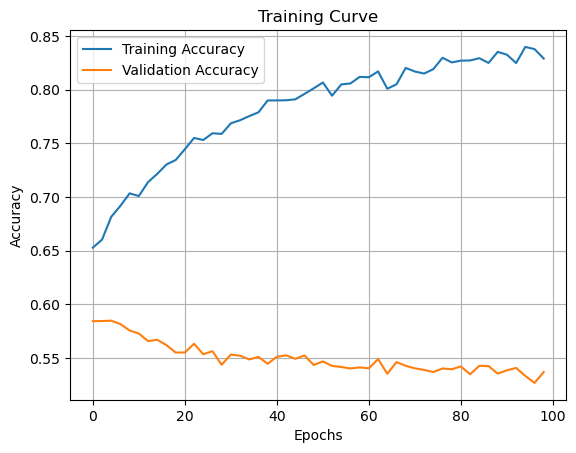

In [6]:
# Plot training curve
plt.plot(resnet18_noreg_df['epochs'], resnet18_noreg_df['training accuracy'], label='Training Accuracy')
plt.plot(resnet18_noreg_df['epochs'], resnet18_noreg_df['validation accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [7]:
# Model with best validation accuracy
resnet18_noreg_df[resnet18_noreg_df['validation accuracy'] == resnet18_noreg_df['validation accuracy'].max()]

,epochs,training accuracy,validation accuracy
2,4,0.681529,0.584787


### ResNet18 with regularization

In [8]:
# Load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
resnet.name = 'ResNet18'

# Freeze parameters in ResNet architecture
for param in resnet.parameters():
    param.requires_grad = False

# Modify the top layer
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 55),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(55, 11))

C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Training results

In [9]:
resnet18_withreg_df = pd.read_csv('ResNet18_withreg_results.csv')
resnet18_withreg_df.head()

,epochs,training accuracy,validation accuracy
0,0,0.455373,0.454669
1,2,0.495555,0.494743
2,4,0.510969,0.502659
3,6,0.520771,0.520099
4,8,0.526631,0.514038


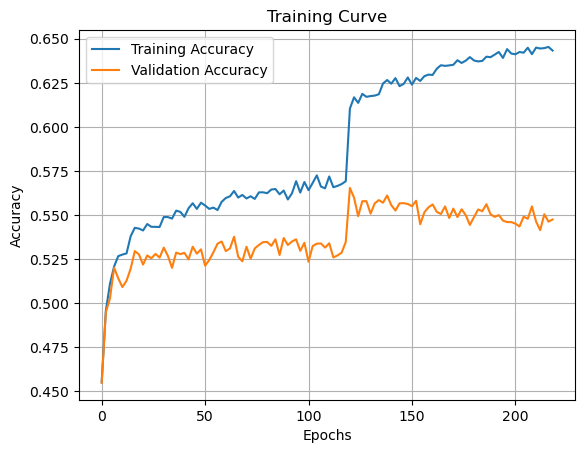

In [10]:
# Plot training curve
plt.plot(resnet18_withreg_df['epochs'], resnet18_withreg_df['training accuracy'], label='Training Accuracy')
plt.plot(resnet18_withreg_df['epochs'], resnet18_withreg_df['validation accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [11]:
# Model with best validation accuracy
resnet18_withreg_df[resnet18_withreg_df['validation accuracy'] == resnet18_withreg_df['validation accuracy'].max()]

,epochs,training accuracy,validation accuracy
60,120,0.61038,0.565368


### ResNet101 no regularization

Training was done with batch_size = 64, lr = 0.001

In [ ]:
# Load pre-trained ResNet model
resnet = models.resnet101(pretrained=True)
resnet.name = 'ResNet101'

# Freeze parameters in ResNet architecture
for param in resnet.parameters():
    param.requires_grad = False

# Modify the top layer
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 66),
    nn.ReLU(),
    nn.Linear(66, 11))

#### Training results

In [12]:
resnet101_noreg_df = pd.read_csv('ResNet101_noreg_results.csv')
resnet101_noreg_df.head()

,epochs,training accuracy,validation accuracy
0,0,0.563860,0.561905
1,2,0.593234,0.579716
2,4,0.605263,0.583426
3,6,0.627340,0.595547
4,8,0.644672,0.610019


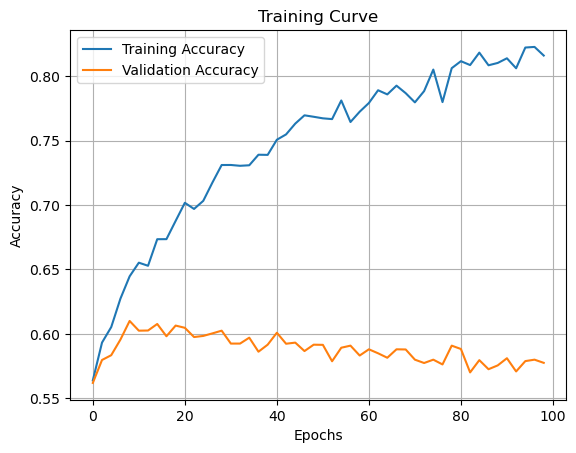

In [13]:
# Plot training curve
plt.plot(resnet101_noreg_df['epochs'], resnet101_noreg_df['training accuracy'], label='Training Accuracy')
plt.plot(resnet101_noreg_df['epochs'], resnet101_noreg_df['validation accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [14]:
# Model with best validation accuracy
resnet101_noreg_df[resnet101_noreg_df['validation accuracy'] == resnet101_noreg_df['validation accuracy'].max()]

,epochs,training accuracy,validation accuracy
4,8,0.644672,0.610019


## WikiART9 entire dataset

### ResNet101 no regularization

Trained on the entire dataset with batchsize = 64, lr=0.001

In [ ]:
# Load pre-trained ResNet model
resnet = models.resnet101(pretrained=True)
resnet.name = 'ResNet101'

# Freeze parameters in ResNet architecture
for param in resnet.parameters():
    param.requires_grad = False

# Modify the top layer
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 66),
    nn.ReLU(),
    nn.Linear(66, 11))

#### Training Results

In [15]:
resnet101_ART9_noreg_df = pd.read_csv('ResNet101_ART9_noreg_results.csv')
resnet101_ART9_noreg_df.head()

,epochs,training accuracy,validation accuracy
0,0,0.480536,0.478307
1,1,0.499805,0.493327
2,2,0.508243,0.499675
3,3,0.512710,0.503879
4,4,0.516912,0.505484


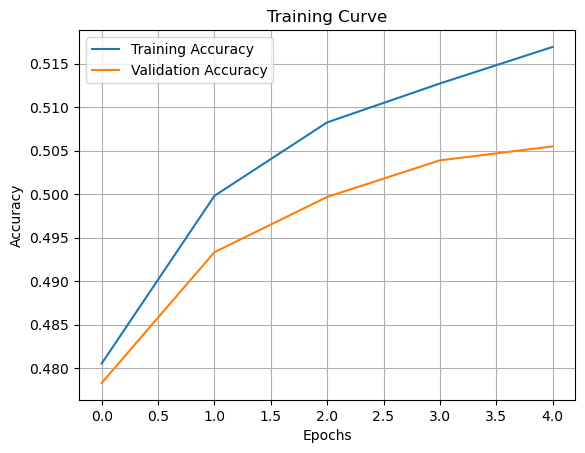

In [16]:
# Plot training curve
plt.plot(resnet101_ART9_noreg_df['epochs'], resnet101_ART9_noreg_df['training accuracy'], label='Training Accuracy')
plt.plot(resnet101_ART9_noreg_df['epochs'], resnet101_ART9_noreg_df['validation accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [17]:
# Model with best validation accuracy
resnet101_ART9_noreg_df[resnet101_ART9_noreg_df['validation accuracy'] == resnet101_ART9_noreg_df['validation accuracy'].max()]

,epochs,training accuracy,validation accuracy
4,4,0.516912,0.505484


## WikiART9 center crop

### ResNet101 no regularization

Trained on the entire dataset with batchsize = 64, lr=0.001

In [ ]:
# Load pre-trained ResNet model
resnet = models.resnet101(pretrained=True)
resnet.name = 'ResNet101'

# Freeze parameters in ResNet architecture
for param in resnet.parameters():
    param.requires_grad = False

# Modify the top layer
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 66),
    nn.ReLU(),
    nn.Linear(66, 11))

#### Training Results

In [67]:
resnet101_centercrop_noreg_df = pd.read_csv('centercrop_results.csv')
resnet101_centercrop_noreg_df.head()

,epochs,accuracy,accuracy@3,precision,recall,F1_score,data_type
0,0,0.572722,0.874580,"[0.4661992465466234, 0.7195421095664433, 0.552...","[0.34583139264086743, 0.6664983590000843, 0.64...","[0.3970942146816434, 0.692005241964509, 0.5940...",training
1,2,0.592171,0.887821,"[0.45513644266381015, 0.6611759799831816, 0.66...","[0.4673963670237178, 0.8005554152989648, 0.577...","[0.46118494071256877, 0.7242206230055795, 0.61...",training
2,4,0.621577,0.907114,"[0.5599195551874411, 0.7250951421534082, 0.574...","[0.36741189256323803, 0.8177227972732094, 0.71...","[0.4436840867021949, 0.768628381086812, 0.6368...",training
3,6,0.640901,0.913088,"[0.5080570189029665, 0.6576542979674328, 0.713...","[0.5090824406147718, 0.8904317091641276, 0.597...","[0.5085692123731677, 0.756542256053399, 0.6504...",training
4,8,0.653831,0.923248,"[0.5652886190613312, 0.7030817858552542, 0.694...","[0.4553640739015327, 0.8985104771520075, 0.654...","[0.5044068957609693, 0.7888728799239826, 0.673...",training


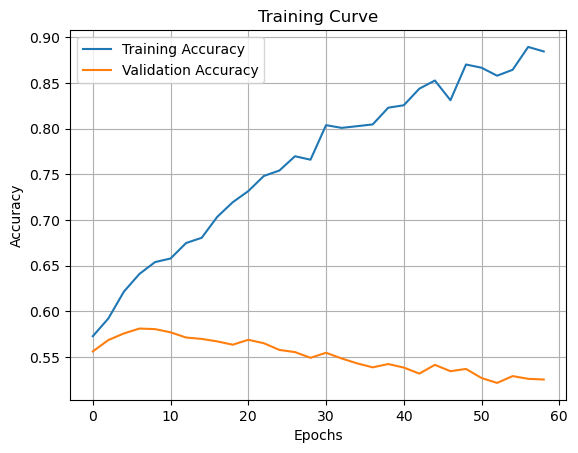

In [68]:
centercrop_train = resnet101_centercrop_noreg_df.loc[resnet101_centercrop_noreg_df['data_type']=='training']
centercrop_val = resnet101_centercrop_noreg_df.loc[resnet101_centercrop_noreg_df['data_type']=='validation']

# Plot training curve
plt.plot(centercrop_train['epochs'], centercrop_train['accuracy'], label='Training Accuracy')
plt.plot(centercrop_val['epochs'], centercrop_val['accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Curve')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

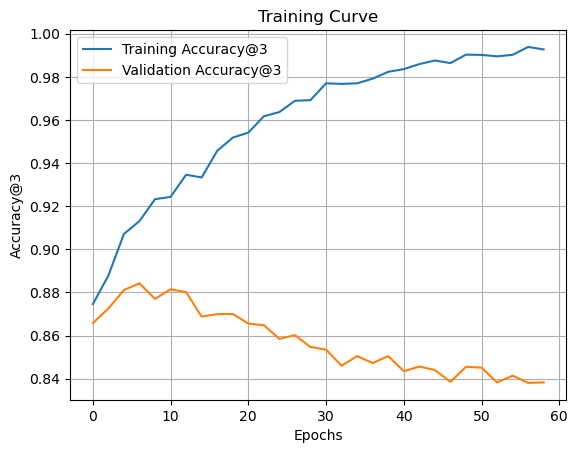

In [69]:
# Plot training curve
plt.plot(centercrop_train['epochs'], centercrop_train['accuracy@3'], label='Training Accuracy@3')
plt.plot(centercrop_val['epochs'], centercrop_val['accuracy@3'], label='Validation Accuracy@3')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy@3')
plt.title('Training Curve')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

In [70]:
# Model with highest validation accuracy
centercrop_val[centercrop_val['accuracy'] == centercrop_val['accuracy'].max()]

,epochs,accuracy,accuracy@3,precision,recall,F1_score,data_type
33,6,0.581103,0.884228,"[0.43630769230742383, 0.5731523378573558, 0.61...","[0.4481668773701339, 0.7692307692292121, 0.497...","[0.4421577793563779, 0.6568712181785037, 0.551...",validation


## Test Results

In [18]:
# Instantiate Data loader
dataset_dir = 'C:/Users/ASUS/Documents/UofT MEng/Winter 2023-2024/MIE1517 Introduction to Deep Learning/Course project/Data/wikiART224_genre'
train_loader, val_loader, test_loader = get_data_loaders(data_dir=dataset_dir)

data loading completed


In [19]:
# Load pre-trained ResNet model
resnet = models.resnet101(pretrained=True)
resnet.name = 'ResNet101'

# Freeze parameters in ResNet architecture
for param in resnet.parameters():
    param.requires_grad = False

# Modify the top layer
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 66),
    nn.ReLU(),
    nn.Linear(66, 11))

model_path = 'model_ResNet101_bs64_lr0.001_epoch8'
state = torch.load(model_path)
resnet.load_state_dict(state)

C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [21]:
use_cuda = True
train_acc, train_acc_at3, train_precision, train_recall, train_f1_score = evaluate_model(resnet, train_loader, k=3)
val_acc, val_acc_at3, val_precision, val_recall, val_f1_score = evaluate_model(resnet, val_loader, k=3)
test_acc, test_acc_at3, test_precision, test_recall, test_f1_score = evaluate_model(resnet, test_loader, k=3)

In [32]:
print(f'Training accuracy: {train_acc}, Training accuracy @ 3: {train_acc_at3}\n')
print(f'Validation accuracy: {val_acc}, Validation accuracy @ 3: {val_acc_at3}\n')
print(f'Test accuracy: {test_acc}, Test accuracy @ 3: {test_acc_at3}')

Training accuracy: 0.6546744793679752, Training accuracy @ 3: 0.9232850450673304

Validation accuracy: 0.6142238713667285, Validation accuracy @ 3: 0.8946196660482375

Test accuracy: 0.6106851348008905, Test accuracy @ 3: 0.8958694039079891


In [25]:
classes = test_loader.dataset.classes
best_model_metrics = pd.DataFrame({'train precision':train_precision,
                                   'val precision':val_precision,
                                   'test precision': test_precision,
                                   'train recall':train_recall,
                                   'val recall':val_recall,
                                   'test recall':test_recall,
                                   'train F1 score':train_f1_score,
                                   'val F1 score':val_f1_score,
                                   'test F1 score':test_f1_score},
                                  index=classes)

display(best_model_metrics)

,train precision,val precision,test precision,train recall,val recall,test recall,train F1 score,val F1 score,test F1 score
Unknown,0.561092,0.506564,0.509245,0.453305,0.413098,0.403049,0.501472,0.455082,0.449966
abstract_painting,0.743299,0.720755,0.740809,0.824805,0.776423,0.791749,0.781933,0.747554,0.765432
cityscape,0.738296,0.684358,0.679525,0.532374,0.502049,0.489316,0.618650,0.579196,0.568944
genre_painting,0.587552,0.554054,0.512644,0.466363,0.408145,0.430918,0.519990,0.470036,0.468241
illustration,0.769958,0.631068,0.592920,0.476283,0.380117,0.348958,0.588519,0.474453,0.439344
landscape,0.697008,0.666280,0.670343,0.879768,0.861423,0.859387,0.777796,0.751388,0.753184
nude_painting,0.679632,0.555556,0.580952,0.425914,0.380435,0.348571,0.523659,0.451613,0.435714
portrait,0.728293,0.707663,0.702737,0.813639,0.778329,0.786325,0.768604,0.741315,0.742185
religious_painting,0.644478,0.579495,0.578488,0.655511,0.588235,0.590504,0.649948,0.583832,0.584435
sketch_and_study,0.517047,0.486188,0.503484,0.728603,0.717391,0.688095,0.604860,0.579583,0.581489


In [39]:
#Create lists to store labels and predictions
all_labels = []
all_predictions = []

# Iterate over the test loader
for imgs, labels in test_loader:
    #############################################
    # To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
    #############################################

    # Forward pass
    output = resnet(imgs)

    # Select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]

    # Convert tensors to numpy arrays and append to lists
    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(pred.cpu().numpy())

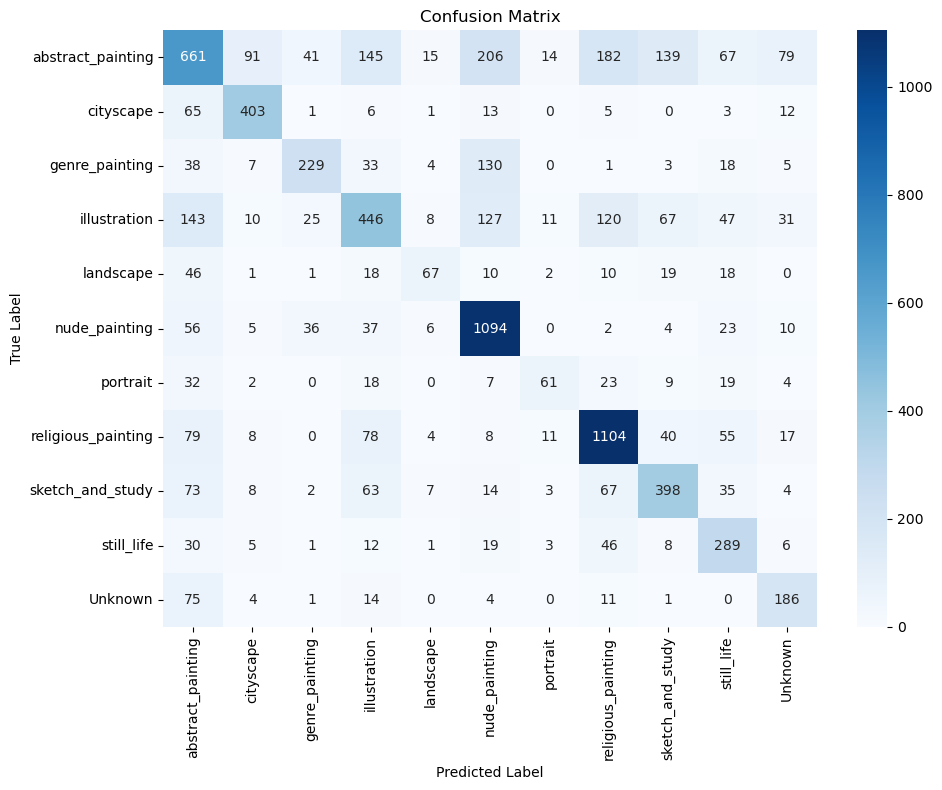

In [40]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# List of all target classes
classes = os.listdir(dataset_dir)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Convert confusion matrix to DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [45]:
# Create lists to store labels and top 3 predictions
all_labels = []
all_top3_predictions = []

# Iterate over the test loader
for imgs, labels in test_loader:
    #############################################
    # To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
    #############################################

    # Forward pass
    output = resnet(imgs)

    # Select top 3 predictions
    top3_preds = output.topk(3, dim=1)[1]

    # Convert tensors to numpy arrays and append to lists
    all_labels.extend(labels.cpu().numpy())
    all_top3_predictions.extend(top3_preds.cpu().numpy())

In [50]:
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_top3_predictions = np.array(all_top3_predictions)

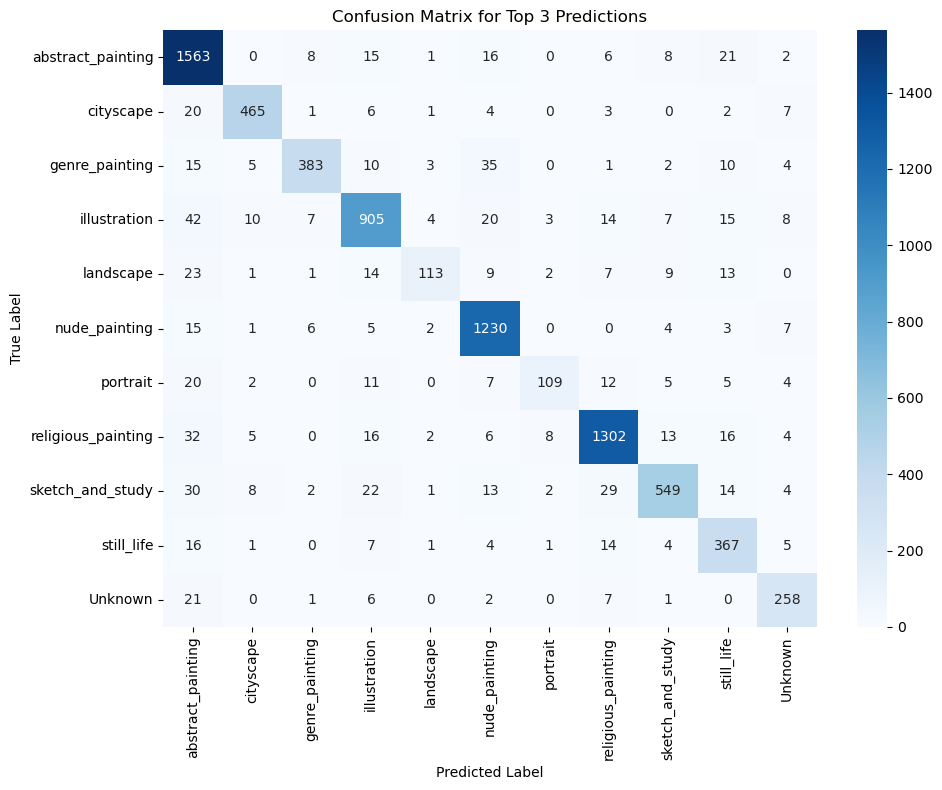

In [63]:
# Initialize confusion matrix for top 3 predictions
conf_matrix_top3 = np.zeros((len(classes), len(classes)), dtype=int)

# Iterate over each sample
for true_label, top3_preds in zip(all_labels, all_top3_predictions):
    # Consider all top 3 predictions
    if true_label in top3_preds:
        conf_matrix_top3[true_label, true_label] += 1
    else:
        conf_matrix_top3[true_label, top3_preds[0]] += 1
        
# Convert confusion matrix to DataFrame for better visualization
conf_matrix_top3_df = pd.DataFrame(conf_matrix_top3, index=classes, columns=classes)

# Plot confusion matrix heatmap for top 3 predictions
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_top3_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Top 3 Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [28]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

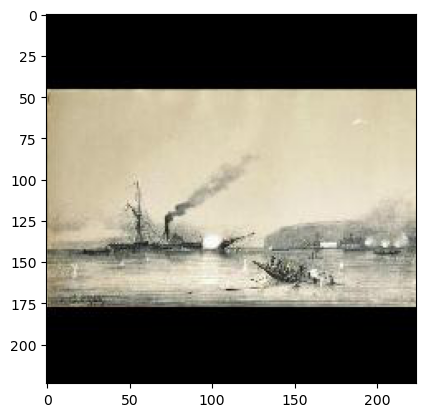

Class: abstract_painting, Probability: 0.3429056704044342
Class: genre_painting, Probability: 0.30730995535850525
Class: nude_painting, Probability: 0.2642209827899933


In [65]:
# Get a random batch of images and labels from the test loader
images, labels = next(iter(test_loader))
idx = random.randint(0, len(images) - 1)
img, label = images[idx], labels[idx]

#Display image
imshow(img)

# Make predictions
resnet.eval()
with torch.no_grad():
    if torch.cuda.is_available():
        img = img.cuda()
    output = resnet(img.unsqueeze(0))  # Add batch dimension
    probabilities = torch.softmax(output, dim=1)[0]  # Convert logits to probabilities
    
# Get the top 3 predicted classes and their probabilities
top3_prob, top3_classes = torch.topk(probabilities, 3)
top3_prob = top3_prob.cpu().numpy()
top3_classes = top3_classes.cpu().numpy()

# Print top 3 classes and their probabilities
for i in range(3):
    print(f"Class: {classes[top3_classes[i]]}, Probability: {top3_prob[i]}")